### Block Data Analysis Script

In [32]:
# this script will take the dataframe outputs from the simulation and analyse/visualise block data and chromsome structure.

In [94]:
#Cell 1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os # For path joining
import re

num_loci_per_chr = 500 #NEEDS TO MATCH SIM SCRIPT

In [95]:
#Cell 2
# Define the path to your saved chromatid_recombination_data.csv
full_path_to_recomb_data = r"C:\Users\sophi\Jupyter_projects\Hybrid_Code\output_data\dataframes\chromatid_recombination_data_test_F100_500.csv"

print(f"Attempting to load data from: {full_path_to_recomb_data}")

try:
    chromatid_recomb_df = pd.read_csv(full_path_to_recomb_data)
    print("Data loaded successfully!")
    print("\n--- Initial glance at the DataFrame ---")
    print(chromatid_recomb_df.head())
    print("\n-DataFrame Info")
    chromatid_recomb_df.info()
except FileNotFoundError:
    print(f"Error: The file '{full_path_to_recomb_data}' was not found.")
    print("Please ensure you have run your simulation script and saved the recombination data.")
    print("Also, double-check the 'data_folder' and 'recombination_data_filename' variables.")
    exit() # Exit the script if data can't be loaded

Attempting to load data from: C:\Users\sophi\Jupyter_projects\Hybrid_Code\output_data\dataframes\chromatid_recombination_data_test_F100_500.csv
Data loaded successfully!

--- Initial glance at the DataFrame ---
  individual_id  diploid_chr_id chromatid_in_pair  total_junctions  \
0             1               1                 A                0   
1             1               1                 B                0   
2             1               2                 A                0   
3             1               2                 B                0   
4             2               1                 A                0   

  block_lengths block_alleles generation  
0         [500]           [0]        P_A  
1         [500]           [0]        P_A  
2         [500]           [0]        P_A  
3         [500]           [0]        P_A  
4         [500]           [0]        P_A  

-DataFrame Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total

In [96]:
# Sort block data for visulaisation

In [97]:
# Cell 3

# If 'block_lengths' or 'block_alleles' are stored as strings (e.g., "[10, 20, 30]"),
# you'll need to convert them to actual lists.
# This is crucial for correctly analysing block lengths.
# Helper function to safely parse string representations of lists
def parse_list_string(s):
    try:
        # Check if it's already a list (if previous processing occurred)
        if isinstance(s, list):
            return s
        # Attempt to evaluate string representation of lists
        parsed = eval(s)
        # Ensure it's a list, even if eval returns a single item (e.g., if string was "10")
        return parsed if isinstance(parsed, list) else [parsed]
    except (SyntaxError, TypeError, NameError):
        # Handle cases where parsing fails (e.g., empty string, non-list string)
        return [] # Return an empty list for invalid entries

# Apply parsing for both 'block_lengths' and 'block_alleles' if they are strings
if 'block_lengths' in chromatid_recomb_df.columns and isinstance(chromatid_recomb_df['block_lengths'].iloc[0], str):
    print("\nConverting 'block_lengths' from string to list...")
    chromatid_recomb_df['block_lengths'] = chromatid_recomb_df['block_lengths'].apply(parse_list_string)

if 'block_alleles' in chromatid_recomb_df.columns and isinstance(chromatid_recomb_df['block_alleles'].iloc[0], str):
    print("Converting 'block_alleles' from string to list...")
    chromatid_recomb_df['block_alleles'] = chromatid_recomb_df['block_alleles'].apply(parse_list_string)

# Explode BOTH 'block_lengths' and 'block_alleles' simultaneously
# This is crucial to pair each block length with its corresponding allele
print("Exploding 'block_lengths' and 'block_alleles' columns...")
exploded_blocks_df = chromatid_recomb_df.explode(['block_lengths', 'block_alleles'])

# Convert exploded 'block_lengths' to numeric, handling potential errors
exploded_blocks_df['block_lengths'] = pd.to_numeric(exploded_blocks_df['block_lengths'], errors='coerce')
exploded_blocks_df.dropna(subset=['block_lengths'], inplace=True) # Remove rows where conversion failed

# Ensure 'block_alleles' is treated as an appropriate type (e.g., int, not object)
# It should contain single 0s or 1s after the explode.
# Using .loc to avoid SettingWithCopyWarning if it arises from complex chains
exploded_blocks_df.loc[:, 'block_alleles'] = exploded_blocks_df['block_alleles'].astype(int)
print("Finished exploding and type conversion for block data.")


Converting 'block_lengths' from string to list...
Converting 'block_alleles' from string to list...
Exploding 'block_lengths' and 'block_alleles' columns...
Finished exploding and type conversion for block data.


In [110]:
print(exploded_blocks_df)

     individual_id  diploid_chr_id chromatid_in_pair  total_junctions  \
0                1               1                 A                0   
1                1               1                 B                0   
2                1               2                 A                0   
3                1               2                 B                0   
4                2               1                 A                0   
...            ...             ...               ...              ...   
4236    BC2B_Ind10               1                 A                1   
4237    BC2B_Ind10               1                 B                0   
4238    BC2B_Ind10               2                 A                1   
4238    BC2B_Ind10               2                 A                1   
4239    BC2B_Ind10               2                 B                0   

      block_lengths block_alleles generation  
0               500           [0]        P_A  
1               500          

### Ancestry Map 


Generating Chromosome Pair Ancestry Map

Visualising: Generation=F2, Individual=F2_Ind1, Diploid Chromosome Pair=1


TypeError: unhashable type: 'list'

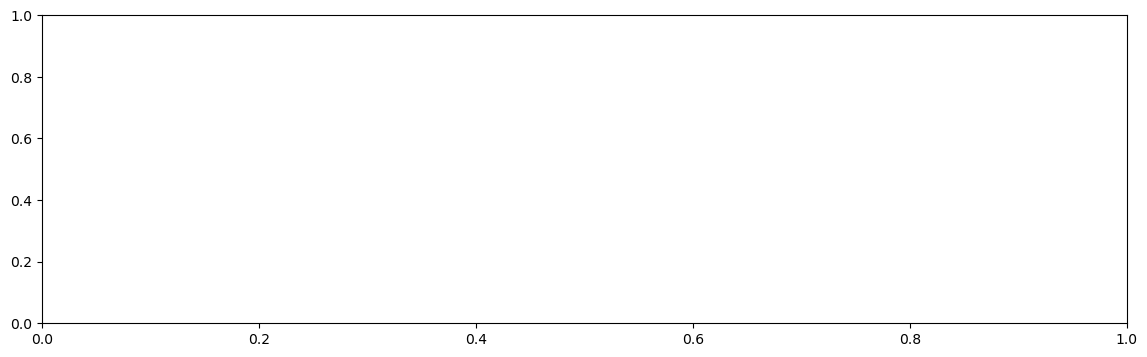

In [105]:
print("\nGenerating Chromosome Pair Ancestry Map")

# --- USER INPUT: Define the specific individual, chromosome pair, AND GENERATION to visualize ---
# Based on your previous dtypes output for individual_id and diploid_chr_id:
selected_generation = 'F2'           # Added: Example 'F4' (as string, common for generations)
selected_individual_id = 'F2_Ind1'         # Must be a string as `individual_id` is 'object'
selected_chromosome_id = 1           # Must be an integer as `diploid_chr_id` is 'int64'

print(f"\nVisualising: Generation={selected_generation}, Individual={selected_individual_id}, Diploid Chromosome Pair={selected_chromosome_id}")

# Filter for the specific individual, chromosome pair, AND GENERATION
target_chromosome_pair_df = exploded_blocks_df[
    (exploded_blocks_df['generation'] == selected_generation) & # NEW FILTER
    (exploded_blocks_df['individual_id'] == selected_individual_id) &
    (exploded_blocks_df['diploid_chr_id'] == selected_chromosome_id)
].copy()

if target_chromosome_pair_df.empty:
    print("Error: No data found for the selected generation, individual, and chromosome pair.")
    print("Please check your input values. Available unique combinations in data (first few rows):")
    # Updated print to show generation too, for easier debugging
    print(exploded_blocks_df[['generation', 'individual_id', 'diploid_chr_id']].drop_duplicates().head(10))
else:
    plt.figure(figsize=(14, 4))
    ax = plt.gca()

    # Colors and labels as confirmed by you
    colors = {0: 'magenta', 1: 'gold'} # Allele 0 for Parent M, Allele 1 for Parent Y
    allele_labels = {0: 'Parent M Ancestry (Allele 0)', 1: 'Parent Y Ancestry (Allele 1)'}

    y_pos_map = {'A': 0, 'B': 1}
    y_tick_labels = []
    y_tick_positions = []

    for chromatid_label, group_df in target_chromosome_pair_df.groupby('chromatid_in_pair', sort=False):
        group_df = group_df.reset_index(drop=True)

        group_df['block_end_locus'] = group_df['block_lengths'].cumsum()
        group_df['block_start_locus'] = group_df['block_end_locus'] - group_df['block_lengths']

        y_position = y_pos_map.get(chromatid_label)

        for _, row in group_df.iterrows():
            start = row['block_start_locus']
            length = row['block_lengths']
            allele = row['block_alleles']
            ax.barh(
                y=y_position,
                width=length,
                left=start,
                height=0.8,
                color=colors[allele],
                edgecolor='black',
                linewidth=0.5
            )
        y_tick_positions.append(y_position)
        y_tick_labels.append(f'Chromatid {chromatid_label}')

    ax.set_xlim(0, num_loci_per_chr)
    ax.set_ylim(-0.5, 1.5)

    ax.set_yticks(y_tick_positions)
    ax.set_yticklabels(y_tick_labels)

    ax.set_xlabel('Locus Position Along Chromosome')
    ax.set_title(f'Ancestry Map for Gen: {selected_generation}, Ind: {selected_individual_id}, Chr Pair: {selected_chromosome_id}') # UPDATED TITLE

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='s', color='w', label=allele_labels[0],
               markerfacecolor=colors[0], markersize=10),
        Line2D([0], [0], marker='s', color='w', label=allele_labels[1],
               markerfacecolor=colors[1], markersize=10)
    ]
    ax.legend(handles=legend_elements, loc='upper right', title='Ancestry')

    plt.tight_layout()
    plt.show()

 # Print block counts and junctions for each chromatid 
    print(f"\nAncestry Details for Gen: {selected_generation}, Ind: {selected_individual_id}, Chr Pair: {selected_chromosome_id}")
    
    # Iterate over each unique chromatid ('A' and 'B') from the filtered data
    for chromatid_label, group_df in target_chromosome_pair_df.groupby('chromatid_in_pair', sort=False):
        num_allele_0_blocks = (group_df['block_alleles'] == 0).sum()
        num_allele_1_blocks = (group_df['block_alleles'] == 1).sum()

        # To count junctions, we look for changes in allele sequence
        alleles_sequence = group_df['block_alleles'].tolist()
        junction_count = 0
        if len(alleles_sequence) > 1:
            for i in range(1, len(alleles_sequence)):
                if alleles_sequence[i] != alleles_sequence[i-1]:
                    junction_count += 1
        
        print(f"\nChromatid {chromatid_label}:")
        print(f"  Number of {allele_labels[0]} blocks: {num_allele_0_blocks}")
        print(f"  Number of {allele_labels[1]} blocks: {num_allele_1_blocks}")
        print(f"  Number of junctions (recombination events): {junction_count}")
        
print("\nChromosome Pair Ancestry Map Generation complete")

### X axis ordering

In [98]:
custom_gen_order = []

# Parent Generations
parent_labels = ['P_A', 'P_B']
custom_gen_order.extend(parent_labels)

# Forward Generations (F1, F2, etc.) - Dynamically determine max F-gen
max_f_gen_num = 0
for gen_label in chromatid_recomb_df['generation'].unique():
    if gen_label.startswith('F') and gen_label[1:].isdigit():
        max_f_gen_num = max(max_f_gen_num, int(gen_label[1:]))

f_gen_labels = []
for i in range(1, max_f_gen_num + 1):
    f_gen_label = f'F{i}'
    if f_gen_label in chromatid_recomb_df['generation'].unique():
        f_gen_labels.append(f_gen_label)
custom_gen_order.extend(f_gen_labels)

# Backcross Generations (BC1A, BC1B, etc.) - Dynamically determine max BC-gen
max_bc_gen_num = 0
for gen_label in chromatid_recomb_df['generation'].unique():
    if gen_label.startswith('BC') and gen_label[2:-1].isdigit():
        max_bc_gen_num = max(max_bc_gen_num, int(gen_label[2:-1]))

bc_gen_labels = []
for i in range(1, max_bc_gen_num + 1):
    bc_a_label = f'BC{i}A'
    bc_b_label = f'BC{i}B'
    if bc_a_label in chromatid_recomb_df['generation'].unique():
        bc_gen_labels.append(bc_a_label)
    if bc_b_label in chromatid_recomb_df['generation'].unique():
        bc_gen_labels.append(bc_b_label)
custom_gen_order.extend(bc_gen_labels)

print("\nConstructed Custom Generation Order (Full list of all detected generations):")
print(custom_gen_order)


Constructed Custom Generation Order (Full list of all detected generations):
['P_A', 'P_B', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28', 'F29', 'F30', 'F31', 'F32', 'F33', 'F34', 'F35', 'F36', 'F37', 'F38', 'F39', 'F40', 'F41', 'F42', 'F43', 'F44', 'F45', 'F46', 'F47', 'F48', 'F49', 'F50', 'F51', 'F52', 'F53', 'F54', 'F55', 'F56', 'F57', 'F58', 'F59', 'F60', 'F61', 'F62', 'F63', 'F64', 'F65', 'F66', 'F67', 'F68', 'F69', 'F70', 'F71', 'F72', 'F73', 'F74', 'F75', 'F76', 'F77', 'F78', 'F79', 'F80', 'F81', 'F82', 'F83', 'F84', 'F85', 'F86', 'F87', 'F88', 'F89', 'F90', 'F91', 'F92', 'F93', 'F94', 'F95', 'F96', 'F97', 'F98', 'F99', 'F100', 'BC1A', 'BC1B', 'BC2A', 'BC2B']


### Junction Visualisation

In [99]:
# Cell 4

print("\n--- Total Junctions for Each Individual Chromatid ---")

# Display the columns relevant to individual chromatid recombination counts
# This will show 'total_junctions' for each unique combination of
# individual, chromosome pair, and chromatid (A/B).
individual_junction_data = chromatid_recomb_df[[
    'generation',
    'individual_id',
    'diploid_chr_id',
    'chromatid_in_pair',
    'total_junctions'
]]

# print(individual_junction_data)

# You can also inspect the first few rows if the DataFrame is very large:
# print(individual_junction_data.head(20)) # Shows the first 20 individual entries

# If you want to see all the chromatids for a specific individual, you can filter:
# print("\n--- Total Junctions for Individual 'F1_Ind1' ---")
# print(individual_junction_data[individual_junction_data['individual_id'] == 'F1_Ind1'])

# Or for a specific generation:
print("\n--- Total Junctions for all individuals in 'F100' generation ---")
print(individual_junction_data[individual_junction_data['generation'] == 'F100'])


--- Total Junctions for Each Individual Chromatid ---

--- Total Junctions for all individuals in 'F100' generation ---
     generation individual_id  diploid_chr_id chromatid_in_pair  \
4040       F100     F100_Ind1               1                 A   
4041       F100     F100_Ind1               1                 B   
4042       F100     F100_Ind1               2                 A   
4043       F100     F100_Ind1               2                 B   
4044       F100     F100_Ind2               1                 A   
4045       F100     F100_Ind2               1                 B   
4046       F100     F100_Ind2               2                 A   
4047       F100     F100_Ind2               2                 B   
4048       F100     F100_Ind3               1                 A   
4049       F100     F100_Ind3               1                 B   
4050       F100     F100_Ind3               2                 A   
4051       F100     F100_Ind3               2                 B   
4052    

Constructed Custom Generation Order (Full):
['P_A', 'P_B', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28', 'F29', 'F30', 'F31', 'F32', 'F33', 'F34', 'F35', 'F36', 'F37', 'F38', 'F39', 'F40', 'F41', 'F42', 'F43', 'F44', 'F45', 'F46', 'F47', 'F48', 'F49', 'F50', 'F51', 'F52', 'F53', 'F54', 'F55', 'F56', 'F57', 'F58', 'F59', 'F60', 'F61', 'F62', 'F63', 'F64', 'F65', 'F66', 'F67', 'F68', 'F69', 'F70', 'F71', 'F72', 'F73', 'F74', 'F75', 'F76', 'F77', 'F78', 'F79', 'F80', 'F81', 'F82', 'F83', 'F84', 'F85', 'F86', 'F87', 'F88', 'F89', 'F90', 'F91', 'F92', 'F93', 'F94', 'F95', 'F96', 'F97', 'F98', 'F99', 'F100', 'BC1A', 'BC1B', 'BC2A', 'BC2B']

Analysis: Distribution of Junctions for F-Generations


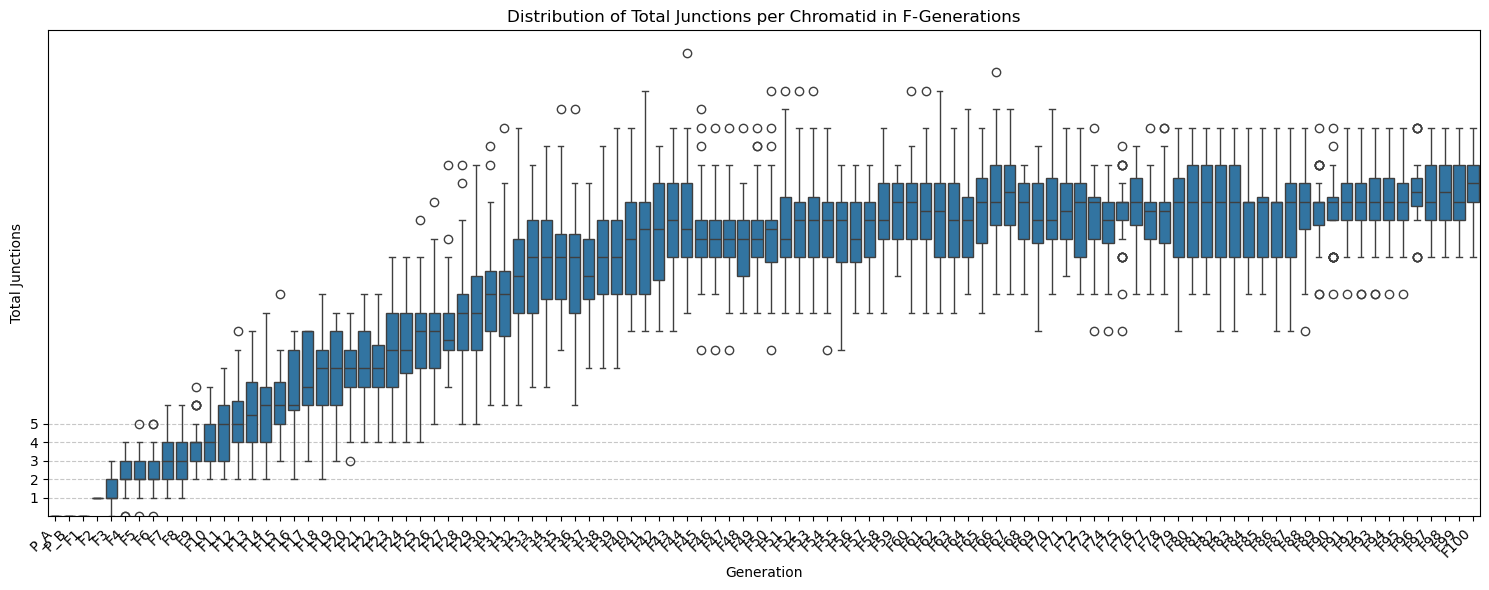

Plot saved to: output_data/df_plots\block_junctions_distribution_f_generations_test.png


<Figure size 640x480 with 0 Axes>

In [109]:
# Cell 5

custom_gen_order = []

# 1. Add Parent Generations
parent_labels = ['P_A', 'P_B']
custom_gen_order.extend(parent_labels)

# 2. Add Forward Generations (F1, F2, F3, etc.)
max_f_gen_num = 0
for gen_label in chromatid_recomb_df['generation'].unique():
    if gen_label.startswith('F') and gen_label[1:].isdigit():
        max_f_gen_num = max(max_f_gen_num, int(gen_label[1:]))

f_gen_labels = []
for i in range(1, max_f_gen_num + 1):
    f_gen_label = f'F{i}'
    if f_gen_label in chromatid_recomb_df['generation'].unique():
        f_gen_labels.append(f_gen_label)
custom_gen_order.extend(f_gen_labels)


# 3. Add Backcross Generations (BC1A, BC1B, BC2A, BC2B, etc.)
max_bc_gen_num = 0
for gen_label in chromatid_recomb_df['generation'].unique():
    if gen_label.startswith('BC') and gen_label[2:-1].isdigit():
        max_bc_gen_num = max(max_bc_gen_num, int(gen_label[2:-1]))

bc_gen_labels = []
for i in range(1, max_bc_gen_num + 1):
    bc_a_label = f'BC{i}A'
    bc_b_label = f'BC{i}B'
    if bc_a_label in chromatid_recomb_df['generation'].unique():
        bc_gen_labels.append(bc_a_label)
    if bc_b_label in chromatid_recomb_df['generation'].unique():
        bc_gen_labels.append(bc_b_label)
custom_gen_order.extend(bc_gen_labels)

print("Constructed Custom Generation Order (Full):")
print(custom_gen_order)

# Define the order specifically for the F-generations plot (Parents + Fs)
f_plot_order = [g for g in custom_gen_order if g in parent_labels or g.startswith('F')]

# Filter the DataFrame for only the generations relevant to this plot
f_gen_df = chromatid_recomb_df[chromatid_recomb_df['generation'].isin(f_plot_order)].copy()

# Ensure the 'generation' column in the filtered DataFrame has the correct categorical order
f_gen_df['generation'] = pd.Categorical(
    f_gen_df['generation'],
    categories=f_plot_order,
    ordered=True
)

print("\nAnalysis: Distribution of Junctions for F-Generations")
plt.figure(figsize=(15, 6)) # Adjust figure size as needed

# Assign the plot to 'ax' here
ax = sns.boxplot(x='generation', y='total_junctions', data=f_gen_df)

plt.title('Distribution of Total Junctions per Chromatid in F-Generations')
plt.xlabel('Generation')
plt.ylabel('Total Junctions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')

# Corrected line: Use set_yticks with a list
ax.set_yticks([1, 2, 3, 4, 5]) # This will place major ticks at 1, 2, 3, 4, 5

plt.ylim(0,) # Ensure y-axis starts from 0
plt.tight_layout()
plt.show() # Remember to call plt.show() to display the plot

save_directory = "output_data/df_plots" # You can change this to any folder name you prefer
plot_filename = "block_junctions_distribution_f_generations_test.png" # Choose a descriptive name

# Create the directory if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
    print(f"Created directory: {save_directory}")

full_save_path = os.path.join(save_directory, plot_filename)

plt.savefig(full_save_path, dpi=300, bbox_inches='tight') # dpi=300 for high quality
print(f"Plot saved to: {full_save_path}")

plt.show() # This will display the plot

In [53]:
# Define the order specifically for the Backcross-generations plot
#bc_plot_order = [g for g in custom_gen_order if g.startswith('BC')]

# Filter the DataFrame for only the generations relevant to this plot
#bc_gen_df = chromatid_recomb_df[chromatid_recomb_df['generation'].isin(bc_plot_order)].copy()

# Ensure the 'generation' column in the filtered DataFrame has the correct categorical order
#bc_gen_df['generation'] = pd.Categorical(
    #bc_gen_df['generation'],
    #categories=bc_plot_order,
    #ordered=True
#)

#print("\n--- Analysis: Distribution of Junctions for Backcross Generations ---")
#plt.figure(figsize=(12, 6)) # Adjust figure size as needed
#sns.violinplot(x='generation', y='total_junctions', data=bc_gen_df)
#plt.title('Distribution of Total Junctions per Chromatid in Backcross Generations')
#plt.xlabel('Generation')
#plt.ylabel('Total Junctions (Crossovers)')
#plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.xticks(rotation=45, ha='right')
#plt.tight_layout()
#plt.show()

# You can also get counts for each number of junctions
#junction_counts_per_gen = chromatid_recomb_df.groupby('generation')['total_junctions'].value_counts().unstack(fill_value=0)
#print("\nCounts of junction numbers per generation:")
#print(junction_counts_per_gen)


### F gen Block Vis

In [101]:
# If 'block_lengths' or 'block_alleles' are stored as strings (e.g., "[10, 20, 30]"),
# you'll need to convert them to actual lists.
# This is crucial for correctly analysing block lengths.
def parse_list_string(s):
    try:
        return eval(s)
    except (SyntaxError, TypeError):
        return []

if 'block_lengths' in chromatid_recomb_df.columns and isinstance(chromatid_recomb_df['block_lengths'].iloc[0], str):
    print("\nConverting 'block_lengths' from string to list...")
    chromatid_recomb_df['block_lengths'] = chromatid_recomb_df['block_lengths'].apply(parse_list_string)

# Explode the list of block lengths into individual rows for easier calculation
# This creates a new DataFrame where each block length gets its own row
exploded_blocks_df = chromatid_recomb_df.explode('block_lengths')

# Convert exploded 'block_lengths' to numeric, handling potential errors
exploded_blocks_df['block_lengths'] = pd.to_numeric(exploded_blocks_df['block_lengths'], errors='coerce')
exploded_blocks_df.dropna(subset=['block_lengths'], inplace=True) # Remove rows where conversion failed


In [102]:
custom_gen_order = []

# 1. Add Parent Generations
parent_labels = ['P_A', 'P_B']
custom_gen_order.extend(parent_labels)

# 2. Add Forward Generations (F1, F2, F3, etc.)
max_f_gen_num = 0
for gen_label in chromatid_recomb_df['generation'].unique():
    if gen_label.startswith('F') and gen_label[1:].isdigit():
        max_f_gen_num = max(max_f_gen_num, int(gen_label[1:]))

f_gen_labels = []
for i in range(1, max_f_gen_num + 1):
    f_gen_label = f'F{i}'
    if f_gen_label in chromatid_recomb_df['generation'].unique():
        f_gen_labels.append(f_gen_label)
custom_gen_order.extend(f_gen_labels)


# 3. Add Backcross Generations (BC1A, BC1B, BC2A, BC2B, etc.)
max_bc_gen_num = 0
for gen_label in chromatid_recomb_df['generation'].unique():
    if gen_label.startswith('BC') and gen_label[2:-1].isdigit():
        max_bc_gen_num = max(max_bc_gen_num, int(gen_label[2:-1]))

bc_gen_labels = []
for i in range(1, max_bc_gen_num + 1):
    bc_a_label = f'BC{i}A'
    bc_b_label = f'BC{i}B'
    if bc_a_label in chromatid_recomb_df['generation'].unique():
        bc_gen_labels.append(bc_a_label)
    if bc_b_label in chromatid_recomb_df['generation'].unique():
        bc_gen_labels.append(bc_b_label)
custom_gen_order.extend(bc_gen_labels)

print("Constructed Custom Generation Order (Full):")
print(custom_gen_order)


Constructed Custom Generation Order (Full):
['P_A', 'P_B', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28', 'F29', 'F30', 'F31', 'F32', 'F33', 'F34', 'F35', 'F36', 'F37', 'F38', 'F39', 'F40', 'F41', 'F42', 'F43', 'F44', 'F45', 'F46', 'F47', 'F48', 'F49', 'F50', 'F51', 'F52', 'F53', 'F54', 'F55', 'F56', 'F57', 'F58', 'F59', 'F60', 'F61', 'F62', 'F63', 'F64', 'F65', 'F66', 'F67', 'F68', 'F69', 'F70', 'F71', 'F72', 'F73', 'F74', 'F75', 'F76', 'F77', 'F78', 'F79', 'F80', 'F81', 'F82', 'F83', 'F84', 'F85', 'F86', 'F87', 'F88', 'F89', 'F90', 'F91', 'F92', 'F93', 'F94', 'F95', 'F96', 'F97', 'F98', 'F99', 'F100', 'BC1A', 'BC1B', 'BC2A', 'BC2B']



 Analysis: Distribution of Block Lengths for F-Generations
Plot saved to: output_data/df_plots\block_lengths_distribution_f_generations_test.png


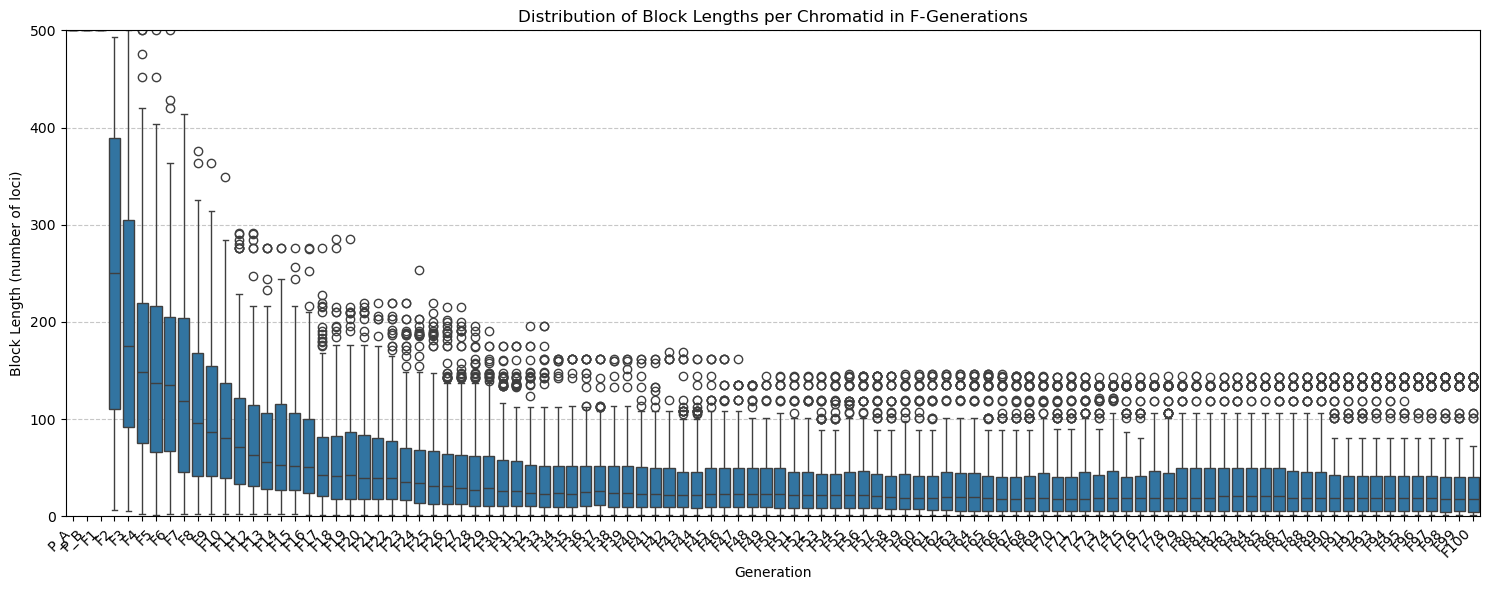

In [103]:
f_plot_order_for_blocks = [g for g in custom_gen_order if g in parent_labels or g.startswith('F')]
f_gen_blocks_df = exploded_blocks_df[exploded_blocks_df['generation'].isin(f_plot_order_for_blocks)].copy()
f_gen_blocks_df['generation'] = pd.Categorical(
    f_gen_blocks_df['generation'],
    categories=f_plot_order_for_blocks,
    ordered=True
)

print("\n Analysis: Distribution of Block Lengths for F-Generations")
plt.figure(figsize=(15, 6))
sns.boxplot(x='generation', y='block_lengths', data=f_gen_blocks_df)
plt.title('Distribution of Block Lengths per Chromatid in F-Generations')
plt.xlabel('Generation')
plt.ylabel('Block Length (number of loci)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, num_loci_per_chr) 
plt.tight_layout()

save_directory = "output_data/df_plots" # You can change this to any folder name you prefer
plot_filename = "block_lengths_distribution_f_generations_test.png" # Choose a descriptive name

# Create the directory if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
    print(f"Created directory: {save_directory}")

full_save_path = os.path.join(save_directory, plot_filename)

plt.savefig(full_save_path, dpi=300, bbox_inches='tight') # dpi=300 for high quality
print(f"Plot saved to: {full_save_path}")

plt.show() # This will display the plot
# plt.close() # Optional: Close the plot to free up memory if you're generating many plots

### Backcross Block Vis

In [42]:
'''# Define the order specifically for the Backcross-generations plot
bc_plot_order_for_blocks = [g for g in custom_gen_order if g.startswith('BC')]

# Filter the EXPLODED DataFrame for only the generations relevant to this plot
bc_gen_blocks_df = exploded_blocks_df[exploded_blocks_df['generation'].isin(bc_plot_order_for_blocks)].copy()

# Ensure the 'generation' column in the filtered DataFrame has the correct categorical order
bc_gen_blocks_df['generation'] = pd.Categorical(
    bc_gen_blocks_df['generation'],
    categories=bc_plot_order_for_blocks,
    ordered=True
)

print("\n--- Analysis: Distribution of Block Lengths for Backcross Generations (Violin Plot) ---")
plt.figure(figsize=(12, 6))
sns.violinplot(x='generation', y='block_lengths', data=bc_gen_blocks_df) # y='block_lengths'
plt.title('Distribution of Block Lengths per Chromatid in Backcross Generations')
plt.xlabel('Generation')
plt.ylabel('Block Length (number of loci)') # Updated Y-axis label
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

SyntaxError: incomplete input (2995677027.py, line 1)